This is a script for building a NWP visibility forecast post-processing model using Random Forest.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pickle
import time

In [ ]:
data_path = "./"
export_path = "./"

In [21]:
df_train = pd.read_csv(data_path + "df_training.csv")
#df_train[(df_train.vis_obs>100000) | (df_train.vis_forecast>100000)]
#df_train = df_train.drop(df_train[(df_train.vis_obs>100000) | (df_train.vis_forecast>100000)].index)
#print("Original dimension:")
#print(df_train.shape)
#df_train = df_train.sample(frac=0.05)
#df_train = df_train.reset_index()
#print("Sample dimension:")
print(df_train.shape)

df_valid = pd.read_csv(data_path + "df_valid.csv")
#df_valid[(df_valid.vis_obs>100000) | (df_valid.vis_forecast>100000)]
#print("Original dimension:")
#print(df_valid.shape)
#df_test = df_valid.sample(frac=0.015)
#df_valid = df_valid.reset_index()
#print("Sample dimension:")
print(df_valid.shape)

df_test = pd.read_csv(data_path + "df_test.csv")
#df_test[(df_test.vis_obs>100000) | (df_test.vis_forecast>100000)]
#df_test = df_test.drop(df_test[(df_test.vis_forecast_obs>100000) | (df_test.vis_forecast>100000)].index)
#print("Original dimension:")
#print(df_test.shape)
#df_test = df_test.sample(frac=0.015)
#df_test = df_test.reset_index()
#print("Sample dimension:")
print(df_test.shape)

x_train = df_train[['station_alt', 't_forecast', 'vis_forecast']]
y_train = df_train['vis_obs']

x_valid = df_valid[['station_alt', 't_forecast', 'vis_forecast']]
y_valid = df_valid['vis_obs']

x_test = df_test[['station_alt', 't_forecast', 'vis_forecast']]
y_test = df_test['vis_obs']

(7461350, 12)
(683512, 12)
(679514, 12)


In [ ]:
# Model training
for i in [10,20,30]: # try different n_estimators
    for j in [10,20,30]: # try different max_depth

        st = time.time()

        rf = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=18)
        rf.fit(x_train, y_train)
        
        with open('rf_nestimators%s_maxdepth%s.pkl'%(i,j),'wb') as f:
            pickle.dump(rf,f)

        y_pred_valid_rf = rf.predict(x_test)
        valid_error_rf = np.array(y_test['vis_reforecast_obs']) - y_pred_valid_rf

        valid_rmse_rf = np.sqrt(np.mean(valid_error_rf**2))
        
        et = time.time()
        elapsed_time = et - st

        print("Validation RMSE for n_estimators=%s and max_depth=%s: %s (execution time: %s s)"%(i,j,valid_rmse_rf,elapsed_time))

In [22]:
# Open previously trained model
with open('/rf_nestimators30_maxdepth20.pkl', 'rb') as f:
    rf = pickle.load(f)

Text(0.5, 1.0, 'Feature Importances from Random Forest Regressor')

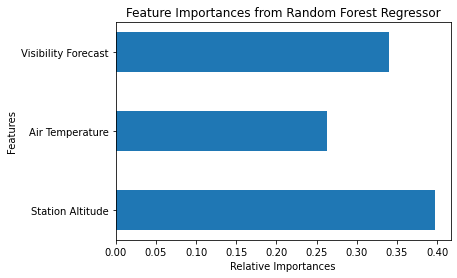

In [23]:
# Feature importance
importances = rf.feature_importances_
plt.barh(np.arange(3), importances, height=0.5)
plt.yticks(np.arange(3), ['Station Altitude','Air Temperature','Visibility Forecast'])
plt.ylabel("Features")
plt.xlabel("Relative Importances")
plt.title("Feature Importances from Random Forest Regressor")

In [24]:
# NWP forecasts (before post-processing)
test_error_forecast = np.array(y_test)-np.array(df_test['vis_forecast'])

In [25]:
# Post-processed forecasts
y_pred_test_rf = rf.predict(x_test)
test_error_rf = np.array(y_test)-y_pred_test_rf

In [27]:
# Baseline model
baseline_by_forecast_time = []
for i in [0,6,12,18]:
    baseline_by_forecast_time.append(np.mean(df_train[df_train['time_in_day']==i]['vis_forecast']))

y_pred_test_baseline = np.array([0]*len(y_test))
for i in range(len(y_test)):
    if df_test['time_in_day'][i]==0:
        y_pred_test_baseline[i] = baseline_by_forecast_time[0]
    elif df_test['time_in_day'][i]==6:
        y_pred_test_baseline[i] = baseline_by_forecast_time[1]
    elif df_test['time_in_day'][i]==12:
        y_pred_test_baseline[i] = baseline_by_forecast_time[2]
    elif df_test['time_in_day'][i]==18:
        y_pred_test_baseline[i] = baseline_by_forecast_time[3]
        
test_error_baseline = np.array(y_test)-y_pred_test_baseline

In [28]:
# Create a dataframe for storing test results
df_result_test = df_test
df_result_test['vis_rf'] = y_pred_test_rf
df_result_test['vis_baseline'] = y_pred_test_baseline
df_result_test['error_forecast'] = test_error_forecast
df_result_test['error_rf'] = test_error_rf
df_result_test['error_baseline'] = test_error_baseline

0        -19153.0
1         -7153.0
2        -22153.0
3        -17153.0
4        -10153.0
           ...   
679509   -20438.0
679510   -11835.0
679511     6575.0
679512    11339.0
679513   -21973.0
Name: error_baseline, Length: 679514, dtype: float64

In [29]:
df_result_test.to_csv(export_path + "df_result_test.csv")